In [1]:
import numpy as np
import thewalrus as tw
import shutil
import multipartite_state as mss
import symplectic as sp 

np.set_printoptions(linewidth=320, edgeitems=999)


In [24]:
BS = tw.symplectic.beam_splitter(np.pi/4,0)

R = np.array([[1,0],[0,0]])
P = tw.symplectic.expand(R,np.array([0,1,2,3]),4)
1/(P @ np.ones((8,8)) @ P)




C:\Users\romjer\AppData\Local\Temp\ipykernel_29288\2769016474.py:5: RuntimeWarning: divide by zero encountered in divide
  1/(P @ np.ones((8,8)) @ P)


array([[ 1.,  1.,  1.,  1., inf, inf, inf, inf],
       [ 1.,  1.,  1.,  1., inf, inf, inf, inf],
       [ 1.,  1.,  1.,  1., inf, inf, inf, inf],
       [ 1.,  1.,  1.,  1., inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf]])

### Test implementation of single modes gates

In [ ]:
cs = ms.cluster_state()
cs.state.cov = cs.state.cov +1
cs.squeeze_initial_state(r= 0.2)
A = cs.state.cov.copy()
cs.rotate_half_state(-np.pi/2)
cs.rotate_half_state(np.pi/2)
np.allclose(A,cs.state.cov)

True

#### Comparison with thewalrus entire calculation

In [2]:
import multipartite_state as ms
cs = ms.cluster_state()
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
cs.state.cov = cs.state.cov +1
S = tw.symplectic.squeezing(0.2)

F = tw.symplectic.expand(S,list(np.arange(N*ms,N*ms*depth)),N*ms*depth)
COV = cs.state.cov.copy()
cs.apply_squeezing(r= 0.2)
np.allclose(F@COV@F.conj().T,cs.state.cov)

False

In [10]:
import multipartite_state as ms
cs = ms.cluster_state()
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
cs.state.cov = cs.state.cov +1
R = tw.symplectic.rotation(-np.pi/8)

F = tw.symplectic.expand(R,np.arange(N*ms+1,N*ms*depth,2),N*ms*depth)
P= cs.P(N = N*ms*(depth-1)//2,
                   modes = np.arange(N*ms+1,N*ms*depth,2)//2 - N*ms,
                   theta = np.pi/3)
slices = np.ix_(np.concatenate([np.arange(N*ms+1,N*ms*depth,2)+N*ms*depth,np.arange(N*ms+1,N*ms*depth,2)]),np.concatenate([np.arange(N*ms+1,N*ms*depth,2)+N*ms*depth,np.arange(N*ms+1,N*ms*depth,2)]))
print(np.allclose(P,F[slices]))
COV = cs.state.cov.copy()
cs.apply_rotation_halfstate(-np.pi/8)
np.allclose(F@COV@F.conj().T,cs.state.cov)

False


True

The strategie used works and save time by applying calculation only on needed element of the cov matrix

---

### Test implementation of the BS among different modes

In [ ]:
import multipartite_state as ms
cs = ms.cluster_state()
cs.state.mu += 1
cs.state.cov +=1
cs.apply_beamsplitter(0) 
A = cs.state.cov
B = cs.state.mu

(256, 256)
(256, 256)


In [ ]:
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
indices = cs.BS_indices[0]
F = cs.BS(N = N*ms*depth,
                     modesA = indices[0],
                     modesB = indices[1])

C = np.eye(N*ms*depth*2)*1/2+1
M = np.zeros(N*ms*depth*2)+1
print(np.allclose(F@M,B))
np.allclose(F@C@F.conj().T,A)


(256, 256)
True


True

##### It does freaking Work!!!!!!!!!

---

### Test run_calculation

In [2]:
import multipartite_state as ms
cs = ms.cluster_state()
cs.state.mu += 1
cs.state.cov +=1

COV = np.array(cs.state.cov)
MU = np.array(cs.state.mu)
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth

S = tw.symplectic.squeezing(0.6)
SQZ= tw.symplectic.expand(S,list(np.arange(N*ms,N*ms*depth)),N*ms*depth)

R = tw.symplectic.rotation(-np.pi/9)
ROT= tw.symplectic.expand(R,list(np.arange(N*ms+1,N*ms*depth,2)),N*ms*depth)

R2 = tw.symplectic.rotation(np.pi/7)
ROT2= tw.symplectic.expand(R2,list(np.arange(N*ms+1,N*ms*depth,2)),N*ms*depth)



COV = SQZ @ COV @ SQZ.conj().T
MU = SQZ @ MU

print("Squeezing")
cs.apply_squeezing(0.6)
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

COV = ROT @ COV @ ROT.conj().T
MU = ROT @ MU

print("Rotation 1")
cs.apply_rotation_halfstate(-np.pi/9)
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

for i in range(len(cs.BS_indices)):
    indices = cs.BS_indices[i]
    F = cs.BS(N = N*ms*depth,
                        modesA = indices[0],
                        modesB = indices[1])
    COV = F @ COV @ F.conj().T
    MU = F @ MU
    print(f"BS {i}")
    cs.apply_beamsplitter(i)
    print(np.allclose(cs.state.mu,MU))
    print(np.allclose(cs.state.cov,COV))
    if i == 0:
        COV = ROT2 @ COV @ ROT2.conj().T
        MU = ROT2 @ MU
        print("Rotation 2")
        cs.apply_rotation_halfstate(np.pi/7)
        print(np.allclose(cs.state.mu,MU))
        print(np.allclose(cs.state.cov,COV))


Squeezing
True
True
Rotation 1
True
True
BS 0
True
True
Rotation 2
True
True
BS 1
True
True
BS 2
True
True
BS 3
True
True


Implementation works perfectly fine ! Surprinsingly the definition of the rotation are different for thewalrus and mine. Need to rotate with - the angle

In [28]:
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

True
True


### Compare speed

In [3]:
import multipartite_state as mss

In [8]:
%%timeit
cs= mss.cluster_state(spatial_depth=8,n=3,m=3,k=3)
cs.run_calculation(0.6)

8.74 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
cs= mss.cluster_state(spatial_depth=8,n=3,m=3,k=3)
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth

hbar = 1
MU = cs.state.mu
COV = cs.state.cov

indice_rot = np.arange(N*ms+1,N*ms*depth,2)
ROT = cs.P(N = N*ms*depth,
            modes = indice_rot,
            theta = -np.pi/2)
ROT2 = cs.P(N = N*ms*depth,
            modes = indice_rot,
            theta = np.pi/2)
indice_sqz = np.arange(N*ms,N*ms*depth)
SQZ = cs.S(N = N*ms*depth,
                    modes = indice_sqz,
                    r = 0.6)


COV = SQZ @ COV @ SQZ.conj().T
MU = SQZ @ MU

COV = ROT @ COV @ ROT.conj().T
MU = ROT @ MU

for i in range(len(cs.BS_indices)):
    indices = cs.BS_indices[i]
    F = cs.BS(N = N*ms*depth,
                        modesA = indices[0],
                        modesB = indices[1])
    COV = F @ COV @ F.conj().T
    MU = F @ MU
    if i == 0:
        COV = ROT2 @ COV @ ROT2.conj().T
        MU = ROT2 @ MU


11.2 s ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
np.allclose(MU,cs.state.mu)

True

### Plot the state

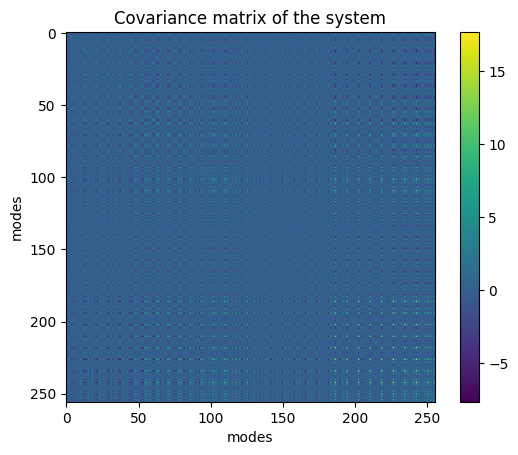

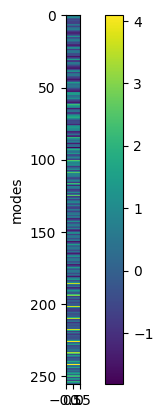

In [29]:
cs.state.plot_cov_matrix()
cs.state.plot_mean_matrix()

In [6]:
cd = mss.cluster_state(k=1, m=1,structure="dual")
cd.run_calculation(0.6)

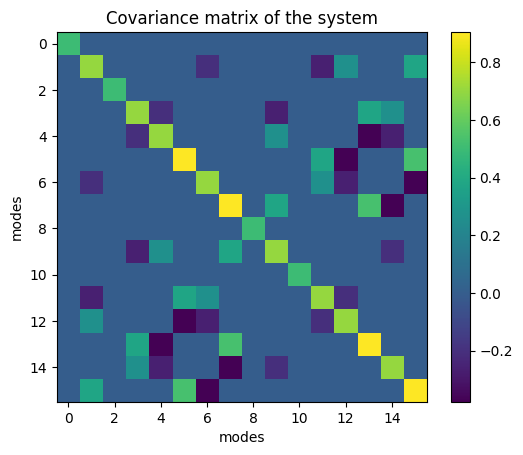

In [7]:
cd.state.plot_cov_matrix()